In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function, absolute_import, division

In [3]:
from copy import deepcopy
import numpy as np
from HeuristicPolicy import HeuristicGomokuPolicy, ThreatSearch
from GomokuBoard import GomokuBoard
from GomokuTools import GomokuTools as gt
from Heuristics import Heuristics, won_or_lost
from UCT_Search import UCT_Node, PolicyAdapter, GomokuEnvironment, GomokuState

In [4]:
A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U = \
    1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK=0
WHITE=1
EDGES=2

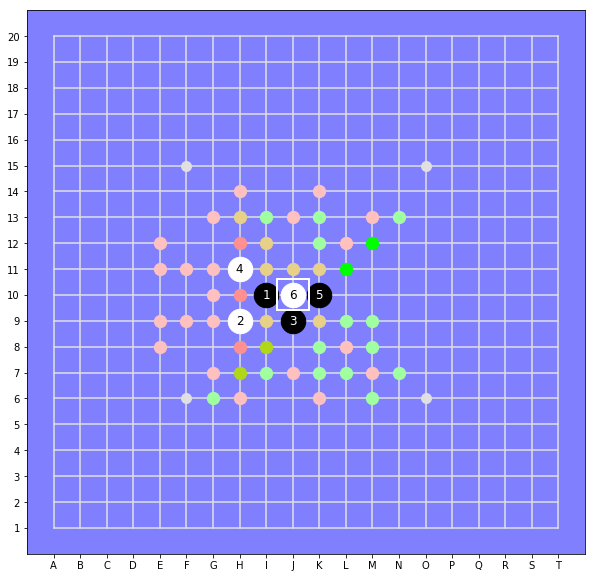

In [5]:
h = Heuristics(kappa=3.0)
board = GomokuBoard(h, N=20, disp_width=10)
p = HeuristicGomokuPolicy(style = 2, bias=.5, topn=5, threat_search=ThreatSearch(2,2))
board.set(I,10).set(H,9).set(J,9).set(H,11).set(K,10).set(J,10)
board.display('current');

In [6]:
p.suggest(board)

Style: 2: (K, 9)

In [7]:
stones = [(G,8), (F,7), (H,7), (F,9), (I,8), (H,8)]
env = GomokuEnvironment(heuristic=h, N=15, disp_width=6, initial_stones=stones)

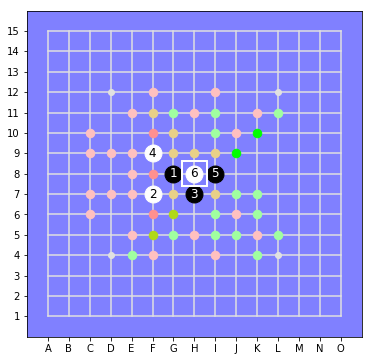

In [8]:
state=env.reset()
board = GomokuBoard(heuristics=h, N=15, disp_width=6, stones=state.stones)
board.display('current')

---

# UCT Step by step

In [9]:
from wgomoku import uct_search, UCT_Node

({(6, 8): 0.889275826212125,
  (6, 11): 0.09334375687783303,
  (7, 6): 7.896974863071689e-06,
  (9, 7): 0.0017915973874967398,
  (9, 9): 0.015580922547682122},
 -0.025250766210376696,
 0)

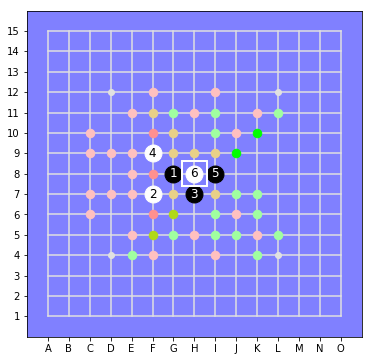

In [10]:
observation=env.reset()
board = GomokuBoard(heuristics=h, N=observation.size, disp_width=6, stones=observation.stones)
strong_policy = HeuristicGomokuPolicy(style = 2, bias=.8, topn=5  
                                      #,threat_search=ThreatSearch(2,2)
                                     )
strong_policy = PolicyAdapter(strong_policy, h)
fast_policy = PolicyAdapter(HeuristicGomokuPolicy(style=2, bias=1.0, topn=5), h)
board.display('current');
distr, value, terminal = fast_policy.evaluate(observation)
distr, value, terminal

In [11]:
root = UCT_Node(observation)
root

TypeError: __init__() missing 1 required positional argument: 'C'

### Select

In [12]:
leaf = root.select_leaf()
leaf

Path: [None]

In [13]:
leaf_priors, value_estimate, terminal = strong_policy.evaluate(leaf.game_state)

In [14]:
leaf_priors, value_estimate, terminal

({(6, 8): 0.011500022575586568,
  (6, 11): 0.7882233397704917,
  (7, 10): 0.0004752799695093827,
  (9, 7): 0.011585762937766612,
  (9, 9): 0.18821559474664576},
 -0.025250766210376696,
 0)

In [15]:
priors = leaf_priors

In [16]:
def _choose_from(distr):
    action_distr = np.rollaxis(np.array([[i[0], i[1]] for i in distr.items()]), -1, 0)
    actions = action_distr[0]
    probas = list(action_distr[1])
    return np.random.choice(actions, 1, p=probas)[0]

In [17]:
move = _choose_from(priors)
print(move)
obs, reward, terminal, info = env.step(move)
priors, value_estimate, terminal = fast_policy.evaluate(obs)
value = won_or_lost(env.board)
priors, value_estimate, value

(6, 11)


({(7, 6): 8.952057678536315e-05,
  (7, 9): 3.1218527816164464e-05,
  (9, 7): 2.40333606380783e-09,
  (10, 9): 0.9997933130617535,
  (11, 10): 8.594543030895518e-05},
 -0.18396340937968134,
 0)

### Rollout

In [18]:
def rollout(env, priors, num_rollouts = 10, max_depth = 10 ):
    rollout_env = deepcopy(env)

    rollout_counter = 0
    sum_values = 0
    depth = 0
    while rollout_counter < num_rollouts:
        while not won_or_lost(rollout_env.board) and depth < max_depth:
            move = _choose_from(priors)
            state, reward, terminal, info = rollout_env.step(move)
            priors, value_estimate, terminal = fast_policy.evaluate(state)
            value = won_or_lost(rollout_env.board)
            if terminal:
                break
            depth += 1
        rollout_counter += 1
        sum_values += (value if value else value_estimate)

    avg_value = sum_values / num_rollouts
    return avg_value

avg_value = rollout(env, priors)
print(avg_value)


-0.2114888939771194


### Backup and expand

In [19]:
leaf.expand(leaf_priors)
leaf.backup(avg_value)

In [20]:
root.child_Q()

array([0., 0., 0., 0., 0.])

### The full algorithm

In [21]:
observation=env.reset()
root = UCT_Node(observation)

for i in range(100):
    leaf = root.select_leaf()
    #print("evaluating strong policy...")
    leaf_priors, value, terminal = strong_policy.evaluate(leaf.game_state)
    #print("done.")
    #print("rollout...")
    if terminal:
        avg_value = value
    else:
        avg_value = rollout(env, leaf_priors, num_rollouts=4, max_depth=5)
    #print("done.")    
    leaf.expand(leaf_priors)
    leaf.backup(avg_value)

In [22]:
root.child_number_visits

array([19., 19., 18., 19., 19.], dtype=float32)

---

# Research

### Playing a well-known threat sequence

#### Status: Unresolved questions

We still can't get the algorithm to reliably detect a threat sequence of 4(x2) moves. Assuming an average branching ratio of 3, which is most likely even too low, we'll end up looking at about 6400 leaves to be potentially explored. The heuristic policies have a forward-looking characteristic of 2 moves. Without the policies to improve themselves in an RL setup we'll never get anywhere.

We have another open question: the $C$-value for the weight of the upper confidence bound term has such a strong influence on the result that it needs be researched itself. The $U$-term is supposed to add some amount of randomness to the selection. But its effect depends also on the distribution of the $Q$-values. If those are significantly smaller then the $U$-values, then the noise overrides all meaningful signals from the leaves.

Also, it might be useful to utilize the child priors in the algorithm somehow, maybe as weights for the backpropagating value_estimates. This obviously becomes even more useful as policies start learning themselves. 

Then, value estimates provided by the heuristic policies are actually hardly more than noise when one considers their long-term use. Maybe that is the major problem!

In [12]:
stones=gt.string_to_stones(
    'i10h9j9h11k10j10l9l11i12j11i11i9h8i14n7m8m6o8l7k8l6l8n8m7n6n9')


In [13]:
stones=gt.string_to_stones('i10h9j9h11k10j10g6m12k9m9m6k8k13m8h6k11h8n8l8')

In [14]:
stones

[('I', 10),
 ('H', 9),
 ('J', 9),
 ('H', 11),
 ('K', 10),
 ('J', 10),
 ('G', 6),
 ('M', 12),
 ('K', 9),
 ('M', 9),
 ('M', 6),
 ('K', 8),
 ('K', 13),
 ('M', 8),
 ('H', 6),
 ('K', 11),
 ('H', 8),
 ('N', 8),
 ('L', 8)]

In [15]:
b2 = GomokuBoard(heuristics=h, disp_width=10, N=20, stones=stones)

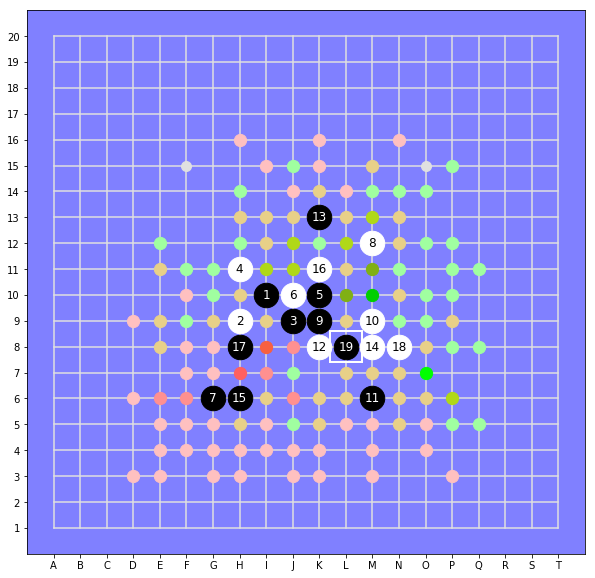

In [16]:
b2.display('current')

Move nr. 16, (K,11) is the brilliant move that starts the winning threat sequence. We want to study the tree search algorithm before and after that move.

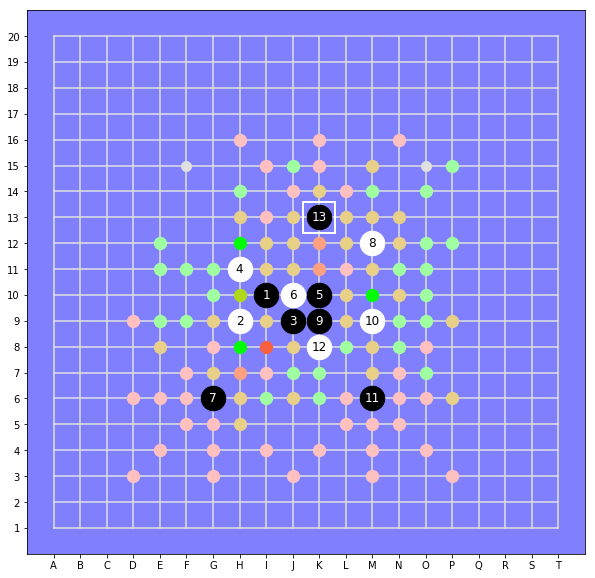

In [17]:
b2.undo().undo().undo().undo().undo().undo().display('current')

In [18]:
env = GomokuEnvironment(heuristic=h, N=20, disp_width=6, initial_stones=b2.stones)

In [19]:
def rollout(env, initial_state, priors, 
            num_rollouts=10, max_depth=10, use_estimates=True):
    rollout_env = deepcopy(env)

    rollout_counter = 0
    sum_values = 0
    depth = 0
    while rollout_counter < num_rollouts:
        while not won_or_lost(rollout_env.board) and depth < max_depth:
            move = _choose_from(priors)
            if move==(0,0):
                print(depth, rollout_counter, rollout_env.board.stones)
            state, reward, terminal, info = rollout_env.step(move)
            
            # change sign if current player is different 
            # from the player at the beginning of this rollout!
            flip = state.to_play * initial_state.to_play
            priors, value_estimate, terminal = fast_policy.evaluate(state)
            if use_estimates:
                value_estimate *= flip
            else:
                value_estimate = 0
            value = flip * won_or_lost(rollout_env.board)
            if terminal:
                break
            depth += 1
        rollout_counter += 1
        sum_values += (value if value else value_estimate)

    avg_value = sum_values / num_rollouts
    return avg_value

In [20]:
observation=env.reset()
root = UCT_Node(observation, C=.5)

for i in range(400):
    leaf = root.select_leaf()
    #print("evaluating strong policy...")
    leaf_priors, value, terminal = strong_policy.evaluate(leaf.game_state)
    #print(leaf, leaf_priors, value)
    #print("done.")
    #print("rollout...")
    if terminal:
        avg_value = value
    else:
        avg_value = rollout(env, leaf.game_state, leaf_priors, 
                            num_rollouts=4, max_depth=5, use_estimates=False)
        leaf.expand(leaf_priors)
    #print("done.")
    leaf.backup(avg_value)

NameError: name '_choose_from' is not defined

In [137]:
root.child_number_visits

array([181.,  63.,  40.,  76.,  34.], dtype=float32)

In [138]:
root.children

[Path: [None, (14, 8)],
 Path: [None, (10, 8)],
 Path: [None, (12, 6)],
 Path: [None, (10, 12)],
 Path: [None, (7, 9)]]

In [139]:
root.child_Q(), root.child_U()

(array([-0.02943396,  0.046875  ,  0.07100862,  0.01937119,  0.11428571],
       dtype=float32),
 array([0.18121009, 0.3055822 , 0.38179138, 0.27859458, 0.41322255],
       dtype=float32))

In [140]:
most_visited = np.argmax(root.child_number_visits)
most_visited

0

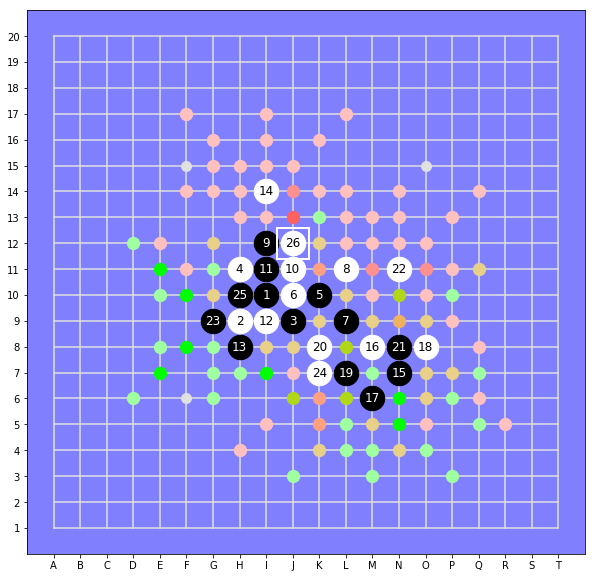

In [141]:
leaf = root
while leaf.is_expanded:
    most_visited = np.argmax(leaf.child_number_visits)
    leaf = leaf.children[most_visited]
b_end = GomokuBoard(disp_width=10, N=20, 
                    heuristics=h, stones = leaf.game_state.stones)
b_end.display('current')

In [39]:
leaf.parent,leaf.parent.child_Q()

(Path: [None, (7, 9), (9, 8), (12, 5)], array([0.17347167], dtype=float32))

In [142]:
root.child_Q()

array([-0.02943396,  0.046875  ,  0.07100862,  0.01937119,  0.11428571],
      dtype=float32)

In [143]:
root.child_U()

array([0.18121009, 0.3055822 , 0.38179138, 0.27859458, 0.41322255],
      dtype=float32)

In [145]:
root.children[2].child_Q()

array([-0.07278384], dtype=float32)

In [146]:
terminal_leaf = root.children[3].children[0].children[0]

In [147]:
terminal_leaf, terminal_leaf.child_Q()

(Path: [None, (10, 12), (7, 12), (14, 8)],
 array([0., 0., 0., 0., 0.], dtype=float32))

In [180]:
terminal_leaf.parent, terminal_leaf.parent.child_Q()

(Path: [None, (11, 11), (8, 8)], array([-0.21137705], dtype=float32))

In [181]:
terminal_leaf.parent.parent, terminal_leaf.parent.parent.child_Q()

(Path: [None, (11, 11)], array([0.20994727], dtype=float32))

In [182]:
terminal_leaf.parent.parent.parent, terminal_leaf.parent.parent.parent.child_Q()

(Path: [None],
 array([ 0.14743568,  0.06312373,  0.01942175, -0.2068005 ,  0.10005508],
       dtype=float32))

In [183]:
root.best_child()

Path: [None, (10, 6)]

### Value oscillation

In [110]:
observation=env.reset()
root = UCT_Node(observation)

for i in range(50):
    leaf = root.select_leaf()
    leaf_priors, value, terminal = fast_policy.evaluate(leaf.game_state)
    if terminal:
        avg_value = value
    else:
        avg_value = rollout(env, leaf_priors, num_rollouts=4, max_depth=5)
        leaf.expand(leaf_priors)
    #print("done.")
    leaf.backup(0)
leaf.backup(1)

In [111]:
leaf.total_value

1.0

In [113]:
leaf.parent.total_value, leaf.parent.parent.total_value

(-1.0, 1.0)

In [169]:
b2.current_color

0